# Stable Diffusion v2.1 using Optimum-Intel OpenVINO and multiple Intel Hardware

This notebook will provide you a way to see different precision models performing in different hardware. This notebook was done for showing case the use of Optimum-Intel-OpenVINO and it is not optimized for running multiple times.

![](https://github.com/openvinotoolkit/openvino_notebooks/assets/10940214/1858dae4-72fd-401e-b055-66d503d82446)


#### Table of contents:

- [Showing Info Available Devices](#Showing-Info-Available-Devices)
- [Configure Inference Pipeline](#Configure-Inference-Pipeline)
- [Using full precision model in choice device with OVStableDiffusionPipeline](#Using-full-precision-model-in-choice-device-with-OVStableDiffusionPipeline)
  

Optimum Intel is the interface between the Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures. More details in this [repository](https://github.com/huggingface/optimum-intel#openvino). 

`Note: We suggest you to create a different environment and run the following installation command there.`

In [ ]:
%pip install -q "optimum-intel[openvino,diffusers]@git+https://github.com/huggingface/optimum-intel.git" "ipywidgets" "transformers>=4.33.0" "torch>=2.1" --extra-index-url https://download.pytorch.org/whl/cpu

Stable Diffusion pipeline should brings 6 elements together, a text encoder model with a tokenizer, a UNet model with and scheduler, and an Autoencoder with Decoder and Encoder models. 

![image ](https://github.com/openvinotoolkit/openvino_notebooks/assets/10940214/e166f225-1220-44aa-a987-84471e03947d)

The base model used for this example is the stabilityai/stable-diffusion-2-1-base. This model was converted to OpenVINO format, for accelerated inference on CPU or Intel GPU with OpenVINO's integration into Optimum.

In [1]:
import warnings

warnings.filterwarnings("ignore")

### Showing Info Available Devices
[back to top ⬆️](#Table-of-contents:)

The `available_devices` property shows the available devices in your system. The "FULL_DEVICE_NAME" option to `ie.get_property()` shows the name of the device. Check what is the ID name for the discrete GPU, if you have integrated GPU (iGPU) and discrete GPU (dGPU), it will show `device_name="GPU.0"` for iGPU and `device_name="GPU.1"` for dGPU. If you just have either an iGPU or dGPU that will be assigned to `"GPU"`

In [1]:
import openvino as ov

core = ov.Core()
devices = core.available_devices

for device in devices:
    device_name = core.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: Intel(R) Core(TM) Ultra 7 155H
GPU: Intel(R) Arc(TM) Graphics (iGPU)
NPU: Intel(R) AI Boost


### Configure Inference Pipeline
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO.

In [5]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="CPU",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'GPU', 'NPU', 'AUTO'), value='GPU')

### Using full precision model in choice device with `OVStableDiffusionPipeline`
[back to top ⬆️](#Table-of-contents:)


In [ ]:
from optimum.intel.openvino import OVStableDiffusionPipeline

# download the pre-converted SD v2.1 model from Hugging Face Hub
name = "helenai/stabilityai-stable-diffusion-2-1-base-ov"
ov_pipe = OVStableDiffusionPipeline.from_pretrained(name, compile=False)
ov_pipe.reshape(batch_size=1, height=512, width=512, num_images_per_prompt=1)
ov_pipe.to(device.value)
ov_pipe.compile()

  0%|          | 0/18 [00:00<?, ?it/s]

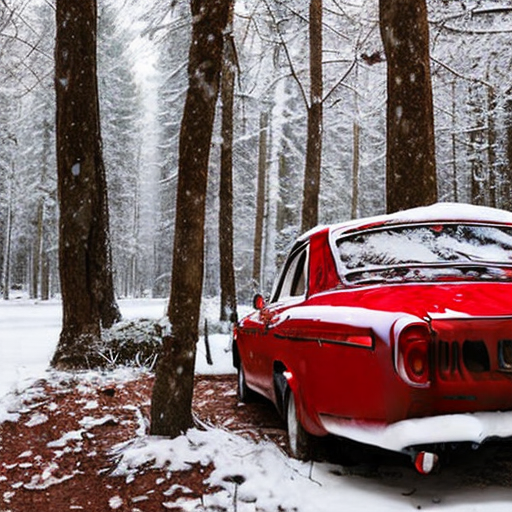

In [8]:
import gc

# Generate an image.
prompt = "red car in snowy forest, epic vista, beautiful landscape, 4k, 8k"
output_ov = ov_pipe(prompt, num_inference_steps=17, output_type="pil").images[0]
output_ov.save("image.png")
output_ov

In [ ]:
del ov_pipe
gc.collect()